## 0. Config

In [ ]:
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'

残り時間 : 11.73

In [ ]:
#ランタイム接続->このセルRun->ランタイムを再起動->このセルRun->pandasVerのVer.1.3.4になっているかを確認
!pip install pandas --upgrade
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.__version__

'1.3.4'

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

class Config:
    def __init__(self):
        self.config = 0
        self.tpu_on = 1
        self.tuner = 0
        self.config_size = 754
        self.data_dir = '/content/drive/MyDrive/GoogleBrain/'
        self.output_dir = '/content/drive/MyDrive/GoogleBrain/output/'
        self.post_processing = {
                                'max_pressure': 64.82099173863948,
                                'min_pressure': -1.8957442945646408,
                                'diff_pressure': 0.07030215,
                                }
        self.today = "20211031LSTM(seluBatch512_2)"
        os.makedirs(self.output_dir + self.today, exist_ok=True)
config = Config()

### 0-1. Libarary

In [ ]:
import gc
import glob
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

!pip install optuna
import optuna
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

#追加（2021/10/22）
from tqdm import tqdm_notebook as tqdm
import time

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 76.8 MB/s 
     |████████████████████████████████| 80 kB 10.3 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 144 kB 79.2 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 111 kB 83.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=91af745ad75971fef4f030366e3a7adac53d7e6841b7f3b5f11e5ea0d61e2020
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## 1. Preprocessing
### 1-1. Train & Test data

In [ ]:
# Dtype Changed for low size data
dtypes = {'id': 'int32',
          'breath_id': 'int32',
          'R' : 'int64',
          'C' : 'int64',
          'time_step': 'float64',
          'u_in': 'float64',
          'u_out': 'int64',
          'pressure': 'float64'}

# Read train CSV data
def read_train():
    train = pd.read_csv(config.data_dir + 'train_del2.csv')
    # Select random breath_id for degug
    if config.config:
        random.seed(2021)
        lst_train = random.sample(set(train['breath_id'].unique()), config.config_size)
        train_tmp = pd.DataFrame()
        for i in lst_train:
            train_tmp = pd.concat([train_tmp, train[train['breath_id'] == i]], axis=0)
        train = train_tmp
    train = train.astype(dtypes)
    return train

# Read test CSV data
def read_test():
    test = pd.read_csv(config.data_dir + 'test.csv')
    # Select random breath_id for degug
    if config.config:
        random.seed(2021)
        lst_test = random.sample(set(test['breath_id'].unique()), config.config_size)
        test_tmp = pd.DataFrame()
        for i in lst_test:
            test_tmp = pd.concat([test_tmp, test[test['breath_id'] == i]], axis=0)
        test = test_tmp
    test = test.astype(dtypes)
    return test

train = read_train()
print(f'train shape: {train.shape}')

train shape: (6012640, 8)


### 1-2. Exploratory Data Analysis
### Feature
- id - globally-unique time step identifier across an entire file
- breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [ ]:
# Describe in exclude id columns
train[train.columns[:]].describe(include='all').round(3)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6012640.000,6012640.000,6012640.000,6012640.000,6012640.000,6012640.000,6012640.000,6012640.000
mean,3017364.264,62825.557,27.029,26.087,1.307,7.322,0.620,11.220
std,1740892.782,36303.004,19.597,17.152,0.766,13.434,0.485,8.109
min,1.000,1.000,5.000,10.000,0.000,0.000,0.000,-1.896
25%,1511240.750,31415.000,5.000,10.000,0.643,0.395,0.000,6.330
50%,3018080.500,62766.500,20.000,20.000,1.308,4.387,1.000,7.033
75%,4524280.250,94253.000,50.000,50.000,1.965,4.984,1.000,13.641
max,6036000.000,125749.000,50.000,50.000,2.937,100.000,1.000,64.821


### 1-3. Time series data(pressure/ u_in / u_out)
- from [https://www.kaggle.com/kaitohonda/beginner-lgbm](https://www.kaggle.com/kaitohonda/beginner-lgbm)

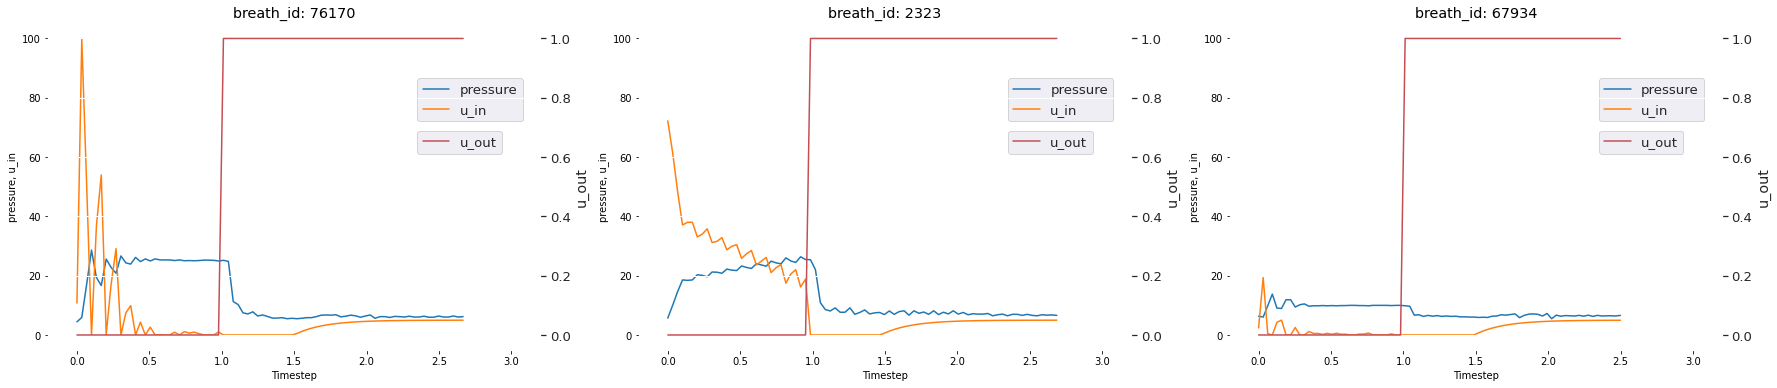

In [ ]:
lst_train = random.sample(set(train['breath_id'].unique()), config.config_size)
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
sns.set(font_scale=1.2)
for i, num in enumerate(random.sample(lst_train, 3)):
    df = train[train['breath_id']==num]
    ax2 = ax[i].twinx()

    sns.lineplot(data=df, x='time_step', y='pressure', label='pressure', ax=ax[i])
    sns.lineplot(data=df, x='time_step', y='u_in', label='u_in', ax=ax[i])
    sns.lineplot(data=df, x='time_step', y='u_out', label='u_out', ax=ax2, color='r')

    ax[i].set(xlabel='Timestep', ylabel='pressure, u_in', title=f'breath_id: {num}', xlim=(-0.2, 3.2), ylim=(-5, 105))
    ax[i].legend(loc=(0.75, 0.7))
    ax2.legend(loc=(0.75, 0.6))
plt.show()

### 1-4. Preprocessing
- https://www.kaggle.com/tfukuda675/simple-lstm

In [ ]:
non_liner_timestep_breath_ids = list()
minus_pressure_breath_ids = list()
u_out_open_step_counts_over52_breath_ids = list()


def log_exp_return(series):
    return np.exp(np.log1p(series).diff(1).fillna(0))

def data_clean(df):
    ## timestepに直線性が無いデータを削除
    time_step_diff_limit = 0.04
    for k, grp in df.groupby("breath_id"):
        diff_se = grp["time_step"].diff()
        diff_chk = diff_se[diff_se > time_step_diff_limit]
        if len(diff_chk) != 0:
            non_liner_timestep_breath_ids.append(k)
    # df = df[~df["breath_id"].isin(non_liner_timestep_breath_ids)]

    ## 負のpressure値を持つデータを削除
    for k, grp in df.groupby("breath_id"):
        m = grp["pressure"].min()
        if m < 0:
            minus_pressure_breath_ids.append(k)
    # df = df[~df["breath_id"].isin(minus_pressure_breath_ids)]
    
    ## u_out = 1のstep数が52以上のデータを削除
    for k, grp in df.groupby("breath_id"):
        count = grp.groupby("u_out")["id"].count()[1]
        if count > 51:
            u_out_open_step_counts_over52_breath_ids.append(k)
    # df = df[~df["breath_id"].isin(u_out_open_step_counts_over52_breath_ids)]
    
    return df

# def cluster_df(df):
#     df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
#     df_cls = pd.DataFrame()
#     for tag in df['R__C'].unique():
#         tmp = df[df["R__C"] == tag]
#         df_tmp = pd.DataFrame()
#         for time in np.arange(0.2, 2.6, 0.2):
#             df_tmp = pd.concat([df_tmp, tmp[(tmp['time_step'] < time) & (tmp['time_step'] >= time - 0.2)]["u_in"].groupby(tmp['breath_id']).agg([np.max, np.mean, np.std]).add_suffix(f"_{time}")], axis=1)
#         df_corr = df_tmp.T.corr().fillna(0)
#         kmeans_diff = KMeans(n_clusters=7, n_init=10, max_iter=300, tol=1e-04, random_state=0).fit(df_corr.values)
#         df_cls = pd.concat([df_cls, pd.DataFrame(kmeans_diff.labels_, index=df_corr.index, columns=['class'])], axis=0).fillna(0)
#         df_cls['class'] = df_cls['class'].astype('str')
#         del tmp, df_tmp, df_corr
#         gc.collect()
        
    df= pd.merge(df, df_cls, on="breath_id", how="left")
    
    del df_cls
    gc.collect()
    
    return df.fillna(0)

def preprocessing(df):   
    # time diff
    df['time_diff'] = df['time_step'].groupby(df['breath_id']).diff(1).fillna(0)
    
    # basic parameter
    df['area'] = df['time_step'] * df['u_in']
    df['area_unit'] = df['u_in'] * df['time_diff']  
    df['u_in_ratio'] = df['u_in'].groupby(df['breath_id']).apply(log_exp_return)
    df['area_ratio'] = df['area_unit'].groupby(df['breath_id']).apply(log_exp_return) 
    df['area_ratio2'] = df['area'].groupby(df['breath_id']).apply(log_exp_return)
    
    # Create Time Windows
    def create_time_window_0(df, time_min, time_max, diff_time):
        feature_dict = {
                        'u_in': [np.max, np.std], 
                        'area_unit': [np.max, np.std], 
                        'u_in_ratio': [np.prod, np.std],
                        'area_ratio': [np.prod, np.std]
                        }
        for time_stamp in np.arange(time_min, time_max, diff_time):
            df_tmp = df[['time_step'] + list(feature_dict.keys())][(df['time_step'] >= time_stamp - diff_time) & (df['time_step'] < time_stamp)] \
                        .groupby(df['breath_id']).agg(feature_dict)
            df_tmp.columns = ['_'.join(col) for col in df_tmp.columns]
            df = pd.merge(df, df_tmp.add_suffix(f'_{time_stamp}_term').reset_index(), on='breath_id', how='left')
            del df_tmp
            gc.collect()
            time.sleep(1)

        return df
    
    def create_time_window_1(df, time_min, time_max, diff_time):
        feature_dict = {
                        'u_in_ratio': [np.prod, np.std],
                        'area_ratio': [np.prod, np.std] 
                        }
        for time_stamp in np.arange(time_min, time_max, diff_time):
            df_tmp = df[['time_step'] + list(feature_dict.keys())][(df['time_step'] <= time_stamp)].groupby(df['breath_id']).agg(feature_dict)
            df_tmp.columns = ['_'.join(col) for col in df_tmp.columns]
            df = pd.merge(df, df_tmp.add_suffix(f'_{time_stamp}_series').reset_index(), on='breath_id', how='left')
            del df_tmp
            gc.collect()
            time.sleep(1)
        return df

    # df = create_time_window_0(df, 0.3, 1.2, 0.3)
    # df = create_time_window_1(df, 0.3, 1.2, 0.3)

    # Shift change 
    for i in np.arange(1, 5, 1):
        df[f'u_in_lag_fwrd{i}'] = df['u_in'].groupby(df['breath_id']).shift(i)
        df[f'u_in_lag_back{i}'] = df['u_in'].groupby(df['breath_id']).shift(int(-i))
        df[f'u_out_lag_fwrd{i}'] = df['u_out'].groupby(df['breath_id']).shift(i)
        df[f'u_out_lag_back{i}'] = df['u_out'].groupby(df['breath_id']).shift(int(-i))
                
        df[f'area_lag_fwrd{i}'] = df['time_diff'] * df[f'u_in_lag_fwrd{i}']
        # df[f'area_lag_back{i}'] = df['time_diff'] * df[f'u_in_lag_back{i}']
        
        df[f'u_in_diff_fwrd{i}'] = df['u_in'] - df[f'u_in_lag_fwrd{i}']
        # df[f'u_in_diff_back{i}'] = df['u_in'] - df[f'u_in_lag_back{i}']

        df[f'area_diff_fwrd{i}'] = df['area_unit'] - df[f'area_lag_fwrd{i}']
        # df[f'area_diff_back{i}'] = df['area_unit'] - df[f'area_lag_back{i}']

        df[f'u_out_diff_fwrd{i}'] = df['u_out'] - df[f'u_out_lag_fwrd{i}']
        # df[f'u_out_diff_back{i}'] = df['u_out'] - df[f'u_out_lag_back{i}']          

    # u_in parameter
    df['last_value_u_in'] = df['u_in'].groupby(df['breath_id']).transform('last')
    df['first_value_u_in'] = df['u_in'].groupby(df['breath_id']).transform('first')
    df['u_in_cumsum'] = df['u_in'].groupby(df['breath_id']).cumsum()
    df['u_in_diff_max'] = df['u_in'].groupby(df['breath_id']).transform('max') - df['u_in']
    df['u_in_diff_ave'] = df['u_in'].groupby(df['breath_id']).transform('mean') - df['u_in']
        
    # area parameter
    df['area_area_cumsum'] = df['area'].groupby(df['breath_id']).cumsum()  
    df['area_unit_cumsum'] = df['area_unit'].groupby(df['breath_id']).cumsum()    
    # df['area_diff_max'] = df['area_unit'].groupby(df['breath_id']).transform('max') - df['area_unit']
    # df['area_diff_ave'] = df['area_unit'].groupby(df['breath_id']).transform('mean') - df['area_unit']
        
    df = df.fillna(0)
    
    # u_out parameter:u_outは値を反転(u_out==1:開放=u_in効力ナシ)
    df['cross_u_in']= df['u_in'] * df['u_out']
    df['cross_area']= df['area_unit'] * df['u_out']
    df['cross_time']= df['time_step'] * df['u_out']
    # df['cross_time_diff']= df['time_diff'] * df['u_out']
    # df['u_out'] = df['u_out'].astype('str')
    
    # R, C parameter
    df['RC'] = df['R'] * df['C'] * 10 ** -3
    df['steady_state'] = df['RC'] * 7

    """
    Integral of u_in*dt (change in time_step times u_in)
    Delta u_in times Delta Time_step
    Slope, delta u_in / delta time_step

    Time_steps we are shifting -1 not (1) :) because we don't want divide by zero :)
    """
    df['u_in_change']= df['u_in'].shift(-1, fill_value=0)-df['u_in'] 
    df['u_in_sh2']=df['u_in'].shift(2, fill_value=0)
    df['delta_time']=df['time_step'].shift(-1, fill_value=0)-df['time_step']
    df['area_u_in']=df['u_in']*df['delta_time']
    df['area_u_in_abs']=df['u_in_change']*df['delta_time']
    df['uin_in_time']=df['u_in_change'] / df['delta_time']
    df['logarithmic_part'] = df['time_step'] / df['RC'] 

    df['transient_f'] = ( df['u_in'] * 10 ** -2 * df['R'] + ( (df['u_in'] * 10 ** -2 * df['time_step']) ) / ( 10 ** -3 * df['C'] ) )  * ( 1 - np.exp( -(df['time_step']) / (df['RC'] ))) 
    # df['t_f_ON'] = df['transient_f'] * ( df['u_out'].map({0:1, 1:0}) )
    # df['t_f_add'] = df['t_f_ON'].cumsum()
    # df['t_f_max'] = df['t_f_add'].max()
    # df['t_f_OFF'] = df['t_f_max'] * (np.exp( -(df['time_step'] * df['u_out']) / (df['RC'] ))) * df['u_out']

    # df['t_f_ON_OFF'] = df['t_f_ON'] + df['t_f_OFF'] 

    df['R'] = df['R'].astype('str')
    df['C'] = df['C'].astype('str')
    df['R__C'] = df["R"].astype('str') + '__' + df["C"].astype('str')
    df = pd.get_dummies(df, drop_first=True) 

    return df

train = data_clean(train)
target = train["pressure"].values
train = train.drop(["id", "pressure"], axis=1)
# train = cluster_df(train)
train = preprocessing(train)
train = train.drop(['breath_id', "R__C_5__10"], axis=1)
feature_column = train.columns.values
train.head(5)

,time_step,u_in,u_out,time_diff,area,area_unit,u_in_ratio,area_ratio,area_ratio2,u_in_lag_fwrd1,u_in_lag_back1,u_out_lag_fwrd1,u_out_lag_back1,area_lag_fwrd1,u_in_diff_fwrd1,area_diff_fwrd1,u_out_diff_fwrd1,u_in_lag_fwrd2,u_in_lag_back2,u_out_lag_fwrd2,u_out_lag_back2,area_lag_fwrd2,u_in_diff_fwrd2,area_diff_fwrd2,u_out_diff_fwrd2,u_in_lag_fwrd3,u_in_lag_back3,u_out_lag_fwrd3,u_out_lag_back3,area_lag_fwrd3,u_in_diff_fwrd3,area_diff_fwrd3,u_out_diff_fwrd3,u_in_lag_fwrd4,u_in_lag_back4,u_out_lag_fwrd4,u_out_lag_back4,area_lag_fwrd4,u_in_diff_fwrd4,area_diff_fwrd4,u_out_diff_fwrd4,last_value_u_in,first_value_u_in,u_in_cumsum,u_in_diff_max,u_in_diff_ave,area_area_cumsum,area_unit_cumsum,cross_u_in,cross_area,cross_time,RC,steady_state,u_in_change,u_in_sh2,delta_time,area_u_in,area_u_in_abs,uin_in_time,logarithmic_part,transient_f,t_f_ON,t_f_add,t_f_max,t_f_OFF,t_f_ON_OFF,R_5,R_50,C_20,C_50,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__20,R__C_5__50
0,0.000000,0.083334,0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,18.383041,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,22.509278,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,22.808822,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,25.355850,0.0,0.0,0.000000,0.000000,0.000000,0.0,4.987079,0.083334,0.083334,28.229702,10.062673,0.000000,0.000000,0.0,0.0,0.0,1.0,7.0,18.299707,0.000000,0.033652,0.002804,0.615827,543.787629,0.000000,0.000000,0.000000,0.000000,6.462704e+06,0.0,0.000000,0,0,0,1,0,1,0,0,0,0,0
1,0.033652,18.383041,0,0.033652,0.618632,0.618632,17.892027,1.618632,1.618632,0.083334,22.509278,0.0,0.0,0.002804,18.299707,0.615827,0.0,0.000000,22.808822,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,25.355850,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,27.259866,0.0,0.0,0.000000,0.000000,0.000000,0.0,4.987079,0.083334,18.466375,9.929994,-8.237035,0.618632,0.618632,0.0,0.0,0.0,1.0,7.0,4.126236,0.000000,0.033862,0.622489,0.139723,121.854067,0.033652,0.125762,0.125762,0.125762,6.462704e+06,0.0,0.125762,0,0,0,1,0,1,0,0,0,0,0
2,0.067514,22.509278,0,0.033862,1.519701,0.762212,1.212879,1.088705,1.556686,18.383041,22.808822,0.0,0.0,0.622489,4.126236,0.139723,0.0,0.083334,25.355850,0.0,0.0,0.002822,22.425944,0.759390,0.0,0.000000,27.259866,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,27.127486,0.0,0.0,0.000000,0.000000,0.000000,0.0,4.987079,0.083334,40.975653,5.803758,-12.363271,2.138333,1.380843,0.0,0.0,0.0,1.0,7.0,0.299544,0.083334,0.034028,0.765942,0.010193,8.802930,0.067514,0.313750,0.313750,0.439512,6.462704e+06,0.0,0.313750,0,0,0,1,0,1,0,0,0,0,0
3,0.101542,22.808822,0,0.034028,2.316059,0.776134,1.012742,1.007901,1.316053,22.509278,25.355850,0.0,0.0,0.765942,0.299544,0.010193,0.0,18.383041,27.259866,0.0,0.0,0.625535,4.425781,0.150600,0.0,0.083334,27.127486,0.0,0.0,0.002836,22.725488,0.773299,0.0,0.000000,26.807732,0.0,0.0,0.000000,0.000000,0.000000,0.0,4.987079,0.083334,63.784476,5.504214,-12.662816,4.454391,2.156978,0.0,0.0,0.0,1.0,7.0,2.547028,18.383041,0.034213,0.780365,0.087142,74.445543,0.101542,0.485197,0.485197,0.924709,6.462704e+06,0.0,0.485197,0,0,0,1,0,1,0,0,0,0,0
4,0.135756,25.355850,0,0.034213,3.442197,0.867507,1.106978,1.051445,1.339601,22.808822,27.259866,0.0,0.0,0.780365,2.547028,0.087142,0.0,22.509278,27.127486,0.0,0.0,0.770117,2.846573,0.097391,0.0,18.383041,26.807732,0.0,0.0,0.628945,6.972809,0.238563,0.0,0.083334,27.864715,0.0,0.0,0.002851,25.272516,0.864656,0.0,4.987079,0.083334,89.140326,2.957185,-15.209844,7.896588,3.024485,0.0,0.0,0.0,1.0,7.0,1.904016,22.509278,0.033942,0.860634,0.064627,56.095783,0.135756,0.731148,0.731148,1.655856,6.462704e+06,0.0,0.731148,0,0,0,1,0,1,0,0,0,0,0


### 1-5. RobustScaler

In [ ]:
rs = RobustScaler()
train = rs.fit_transform(train)
print(f'train shape: {train.shape}')

train shape: (6012640, 77)


## 2. TPU

In [ ]:
if config.tpu_on:
    def detect_strategy():
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            devices = tf.config.list_logical_devices('TPU')
            if len(devices) > 0:
                print("TPU が利用できる")
                return tf.distribute.TPUStrategy(tpu)
        except ValueError:
            pass

        devices = tf.config.list_logical_devices('GPU')
        if len(devices) > 0:
            print("GPU が利用できる")
            return tf.distribute.MirroredStrategy()

        print("CPU が利用できる")
        return tf.distribute.get_strategy()

    strategy = detect_strategy()

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.77.123.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.123.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


TPU が利用できる
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## 3. Keras
### 3-1. Reshape Data
- Data Reshape for Keras

In [ ]:
# Reshape (BreathID, Time_step)
target = target.reshape(-1, 80)

# Reshape (BreathID, Time_step, feature)
train = train.reshape(-1, 80, train.shape[-1])
print(f'train shape: {train.shape}')

train shape: (75158, 80, 77)


### 3-2. Keras Class

In [ ]:
class EarlyStoppingCallback(object):
    """Early stopping callback for Optuna."""
    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds
        self._iter = 0
        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

In [ ]:
#10.35 hr.
class Keras:
    def __init__(self, train, target):
        self.epoch_tuner = 10
        self.epoch = 300
        #250
        self.models = []
        self.results = []
        self.batch_size = 512
        # original 2048
        self.n_splits = 2
        self.n_trials = 100
        self.timeout = 30000
        self.es = EarlyStopping(monitor="val_loss", patience=50, verbose=0, mode="min", restore_best_weights=True)
        self.lr = ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1, factor=0.5, min_lr=0)  
        self.kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=2021)
        self.train, self.target = train, target
        del train, target
        gc.collect()

       
    def create_model(self, n_layer, activation, mid_units, dropout_rate):
        inputs = keras.layers.Input(shape=(self.train.shape[-2], self.train.shape[-1]))
        #x = keras.layers.Bidirectional(keras.layers.LSTM(int(mid_units), return_sequences=True))(inputs)
        # x1 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True))(x)
        # x2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x1)
        # for i in range(0, n_layer):
        #     x = keras.layers.Bidirectional(keras.layers.LSTM(int(mid_units * (0.5**(i+1))), return_sequences=True))(x)
        # x = keras.layers.Dropout(dropout_rate)(x)
        # x = keras.layers.Dense(int(mid_units * (0.5**(i+1)) * 2), activation=activation)(x)
        # output = keras.layers.Dense(1)(x)
        # model = keras.models.Model(inputs, output) 

        # https://www.kaggle.com/hijest/gaps-features-tf-lstm-resnet-like-ff
        x = keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True))(inputs) 
        x1 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True))(x)
        x2 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x1)  
        x3 = tf.keras.layers.Concatenate(axis=2)([x1,x2])
        x4 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x3)
        x5 = keras.layers.Dense(100, activation='selu')(x4)
        x6 = keras.layers.Dense(100, activation='selu')(x5)
        x7 = keras.layers.Dense(100, activation='selu')(x6)
        x7 = tf.keras.layers.Concatenate(axis=2)([x7,x5])
        outputs = keras.layers.Dense(1)(x7)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def objective(self, trial):
        score_lst = []
        n_layer = trial.suggest_int('n_layer', 1, 4) 
        mid_units = trial.suggest_discrete_uniform('mid_units', 256, 512, 64) 
        dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.1) 
        # activation = trial.suggest_categorical('activation', ['relu', 'softplus', 'selu', 'gelu', 'exponential'])
        # activation = trial.suggest_categorical('activation', ['relu', 'selu', 'gelu'])
        activation = trial.suggest_categorical('activation', ['selu'])
        optimizer = trial.suggest_categorical('optimizer', ['adam']) 
        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(self.train, self.target)):
            print("\n" + "="*15 + f'Fold {fold+1} started at {time.ctime()}' + "="*15 + "\n")
            model = self.create_model(n_layer, activation, mid_units, dropout_rate)
            model.compile(optimizer=optimizer, loss="mae", steps_per_execution=32)  
            result =  model.fit(x=self.train[trn_idx], 
                                y=self.target[trn_idx], 
                                batch_size=self.batch_size, 
                                epochs=self.epoch_tuner, 
                                verbose=0, 
                                callbacks=[self.lr, self.es], 
                                validation_data=(self.train[val_idx], self.target[val_idx])
                               )

            score = model.evaluate(self.train[val_idx], self.target[val_idx], verbose=0)

            del result, model, score 
            gc.collect()
            
        return sum(score_lst) / self.n_splits
    
    def optuna_main(self):
        early_stopping = EarlyStoppingCallback(10, direction="minimize")
        study = optuna.create_study()
        study.optimize(self.objective, callbacks=[early_stopping], timeout=self.timeout, n_trials=self.n_trials)
        return study.best_params
    
    def keras_trial(self, params):        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(self.train, self.target)):
            #K.clear_session()
            print("\n" + "="*15 + f'Fold {fold+1} started at {time.ctime()}' + "="*15 + "\n")
            checkpoint_filepath = config.output_dir + config.today + f"/folds{fold+1}.hdf5"
            model = self.create_model(params["n_layer"], 
                                      params["activation"],                                      
                                      params["mid_units"], 
                                      params["dropout_rate"])
            # epoch:?のモデルを指定(reload)
            # model.load_weights(os.path.join('/content/drive/MyDrive/GoogleBrain/output/20211031LSTM(seluBatch128)', "folds2.hdf5"))                                            
            model.summary()
            model.compile(optimizer=params["optimizer"], loss="mae", steps_per_execution=32)

            sv = ModelCheckpoint(checkpoint_filepath, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True,
                                save_weights_only=False, 
                                mode='auto', 
                                save_freq='epoch',
                                options=None)

            result = model.fit(x=self.train[trn_idx], 
                               y=self.target[trn_idx], 
                               batch_size=self.batch_size, 
                               epochs=self.epoch, 
                               verbose=1, 
                               callbacks=[self.lr, self.es, sv], 
                               validation_data=(self.train[val_idx], self.target[val_idx])
                               )
            
            self.results.append(result)
            self.models.append(model)        
            
            del result, model
            gc.collect()
            time.sleep(1)


### 3-3. Keras Trial

In [ ]:
gc.collect()

50

In [ ]:
keras_inst = Keras(train, target)
tmp_params = {'n_layer': 3, 'mid_units': 512, 'dropout_rate': 0.0001, 'activation': 'selu', 'optimizer': 'adam'}

if config.tpu_on:
    with strategy.scope():
        if config.tuner:
            best_params = keras_inst.optuna_main()
            keras_inst.keras_trial(best_params)
        else:
            best_params = tmp_params
            keras_inst.keras_trial(best_params)
            
else:
    if config.tuner:
        best_params = keras_inst.optuna_main()
    else:
        best_params = tmp_params
        keras_inst.keras_trial(best_params)
        
print(best_params)


===============Fold 1 started at Sun Oct 31 15:05:58 2021===============

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 77)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 2048)     9027584     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     10489856    bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 512)      2623488     bidirectional_1[0][0]            
___________________

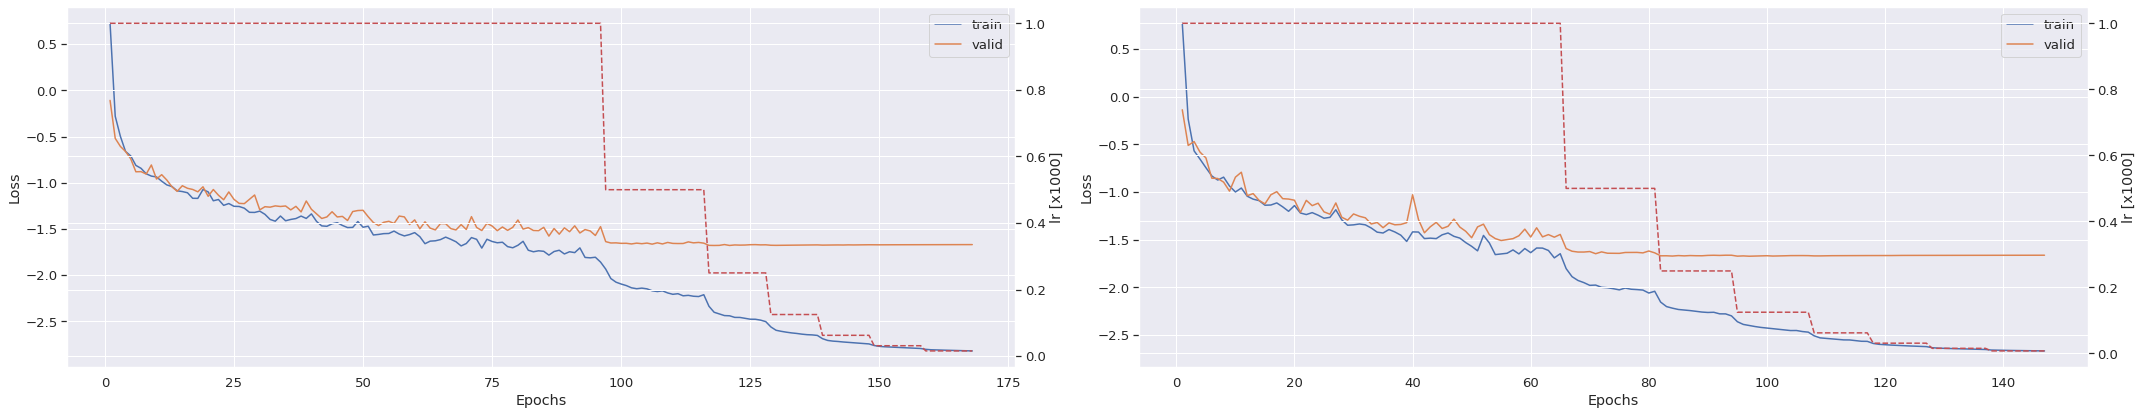


 CV mean score: 0.0646, std: 0.0050.


In [ ]:
if not config.tuner:
    scores = list()   
    fig, ax = plt.subplots(1, keras_inst.n_splits, figsize=(30, 6))
    for i in range(keras_inst.n_splits):
        scores.append(keras_inst.results[i].history['loss'][-1])
        ax2 = ax[i].twinx()
        ax[i].plot(range(1, len(keras_inst.results[i].history['loss'])+1), np.log(keras_inst.results[i].history['loss']), label="train")
        ax[i].plot(range(1, len(keras_inst.results[i].history['val_loss'])+1), np.log(keras_inst.results[i].history['val_loss']), label="valid")
        ax2.plot(range(1, len(keras_inst.results[i].history['lr'])+1), [x * 1000 for x in keras_inst.results[i].history['lr']], label="lr", color="r", ls="--")
        ax[i].set(xlabel='Epochs', ylabel='Loss')
        ax2.set(ylabel="lr [x1000]")
        ax[i].legend()
    plt.tight_layout()
    plt.show()

    print('\n CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [ ]:
if not config.tuner:
    tmp = list()
    for model in keras_inst.models:
        tmp.append(model.predict(train, batch_size=keras_inst.batch_size).squeeze().reshape(-1, 1).squeeze())

    train_pred = read_train()
    train_pred["pred_pressure"] = sum(tmp) / keras_inst.n_splits
    train_pred["mae_unit"] = np.abs(train_pred["pred_pressure"] - train_pred["pressure"])
    train_pred = pd.merge(train_pred, pd.DataFrame(train_pred.groupby("breath_id")["mae_unit"].mean()).rename(columns={"mae_unit": "mae"}), how="left", on="breath_id")
    
    # lst_train_pred = random.sample(set(train_pred['breath_id'].unique()), 3)
    
    # fig, ax = plt.subplots(2, 3, figsize=(30, 12))
    # sns.set(font_scale=1.2)
    # for i, num in enumerate(random.sample(lst_train_pred , 3)):
    #     df = train_pred[train_pred['breath_id']==num]

    #     sns.lineplot(data=df, x='time_step', y='pressure', label='actual', ax=ax[0, i])
    #     sns.lineplot(data=df, x='time_step', y='pred_pressure', label='predict', ax=ax[0, i])
    #     sns.lineplot(data=df, x='time_step', y='u_in', label='u_in', ax=ax[0, i])
    #     sns.lineplot(x=df['time_step'], y=np.log(df['mae_unit']), label='mae_unit', ax=ax[1, i])
    #     ax[0, i].set(xlabel='Timestep', ylabel='pressure, u_in', title=f'breath_id: {num}, MAE: {round(df["mae"].mean(), 3)}', xlim=(-0.2, 3.2))
    #     ax[0, i].legend(loc=(0.75, 0.7))
    #     ax[1, i].set(xlabel='Timestep', ylabel='mae_unit', title=f'breath_id: {num}, MAE: {round(df["mae"].mean(), 3)}', xlim=(-0.2, 3.2), ylim=(-2.1, 0.6))
    #     ax2 = ax[1, i].twinx()
    #     sns.lineplot(data=df, x='time_step', y='u_out', label='u_out', ax=ax2, color='r')
    #     ax[1, i].legend(loc=(0.75, 0.2))
    #     ax2.legend(loc=(0.75, 0.1))

    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

### 3-4. Submission (Keras)

In [ ]:
if not config.tuner:
    dtypes.pop('pressure')
    test = read_test()
    # test = cluster_df(test)
    test = preprocessing(test)
    #列を削除
    test = test.drop(["id", 'breath_id', "R__C_5__10"], axis=1)
    test = rs.transform(test)
    test = test.reshape(-1, 80, test.shape[-1])
    test_shape = test.shape
    print(f'Test Shape: {test.shape}')

    test_preds = []
    for model in keras_inst.models:
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())

    del test
    gc.collect()

    submission = pd.read_csv(config.data_dir + "sample_submission.csv")[:(test_shape[0] * test_shape[1])]
    submission["pressure"] = sum(test_preds) / keras_inst.n_splits
    submission["pressure"] = np.round((submission["pressure"] - config.post_processing["min_pressure"]) / config.post_processing["diff_pressure"]) * config.post_processing["diff_pressure"] + config.post_processing["min_pressure"]
    submission["pressure"] = np.clip(submission["pressure"], config.post_processing["min_pressure"], config.post_processing["max_pressure"])
    submission.to_csv(config.output_dir + config.today + '/submission.csv', index=False)

Test Shape: (50300, 80, 77)


In [ ]:
print(submission.tail(2))

              id   pressure
4023998  4023999  10.407132
4023999  4024000  10.125923


In [ ]:
tmp = list()

# cross validation時のmodelを保管しておく必要があります。modelcheckpointかlistで対応してみてください。
for model in tqdm(keras_inst.models):  # modelによりますが、少し時間がかかります(私の環境Googlecolab proで2-3分)
    tmp.append(model.predict(train, batch_size=keras_inst.batch_size).squeeze().reshape(-1, 1).squeeze())

train_pred = read_train()
# CV計算
train_pred["pred_pressure"] = sum(tmp) / keras_inst.n_splits
# 各時間あたりのMAE
train_pred["mae_unit"] = np.abs(train_pred["pred_pressure"] - train_pred["pressure"])
# 各breath_id時のMAE
mae = pd.DataFrame(train_pred.groupby("breath_id")["mae_unit"].mean()).rename(columns={"mae_unit": "mae"})
train_pred = pd.merge(train_pred, mae, how="left", on="breath_id")

df = train_pred
df['RC'] = df['R'] * df['C'] * 10 ** -3
df['steady_state'] = df['RC'] * 7
df['transient_f'] = ( df['u_in'] * 10 ** -2 * df['R'] + ( (df['u_in'] * 10 ** -2 * df['time_step']) ) / ( 10 ** -3 * df['C'] ) )  * ( 1 - np.exp( -(df['time_step']) / (df['RC'] ))) 
train_pred.head(5)

  0%|          | 0/2 [00:00<?, ?it/s]

,id,breath_id,R,C,time_step,u_in,u_out,pressure,pred_pressure,mae_unit,mae,RC,steady_state,transient_f
0,1,1,20,50,0.000000,0.083334,0,5.837492,5.821192,0.016299,0.089728,1.0,7.0,0.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,5.857898,0.049896,0.089728,1.0,7.0,0.125762
2,3,1,20,50,0.067514,22.509278,0,7.876254,7.928145,0.051891,0.089728,1.0,7.0,0.313750
3,4,1,20,50,0.101542,22.808822,0,11.742872,11.818209,0.075337,0.089728,1.0,7.0,0.485197
4,5,1,20,50,0.135756,25.355850,0,12.234987,12.462068,0.227081,0.089728,1.0,7.0,0.731148


In [ ]:
#MAE を高い順（降順）で並べる
train_pred_s = train_pred.sort_values('mae', ascending=False)
train_pred_s = train_pred_s[0::81]
train_pred_s.to_csv(config.output_dir + config.today + '/train_pred_s.csv', index=False)
train_pred_s.head(20)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,pred_pressure,mae_unit,mae,RC,steady_state,transient_f
2423069,2433150,50558,50,10,0.968674,0.235212,0,1.478759,-0.756259,2.235018,1.967525,0.5,3.5,0.295676
2917943,2929144,60951,50,10,0.733775,5.680877,0,19.405806,24.059450,4.653644,1.966201,0.5,3.5,5.393438
5725657,5748058,119741,50,50,1.826648,4.033084,1,6.892024,6.429928,0.462096,1.850964,2.5,17.5,1.809219
1043516,1050637,21874,50,20,2.426291,4.953537,1,5.907794,6.629021,0.721227,1.842350,1.0,7.0,7.736263
3542977,3555538,74104,50,50,0.540417,9.569915,0,20.038525,24.842327,4.803802,1.828119,2.5,17.5,1.131267
5052536,5068377,105580,5,20,1.785555,3.819298,1,8.087160,8.084160,0.003001,1.743776,0.1,0.7,3.600748
4692428,4707389,98088,50,20,0.894516,7.327716,0,32.763213,28.286598,4.476615,1.616299,1.0,7.0,4.103623
4394570,4408651,91844,50,10,0.334066,0.000000,0,1.408457,-0.197328,1.605784,1.454917,0.5,3.5,0.000000
3650610,3663491,76338,50,10,1.670198,0.040134,1,0.986644,-0.209235,1.195879,1.434547,0.5,3.5,0.084013
190290,191251,3928,50,10,1.669302,0.000000,1,0.705435,-0.671800,1.377235,1.406631,0.5,3.5,0.000000


[ 50558  60951 119741  21874  74104]


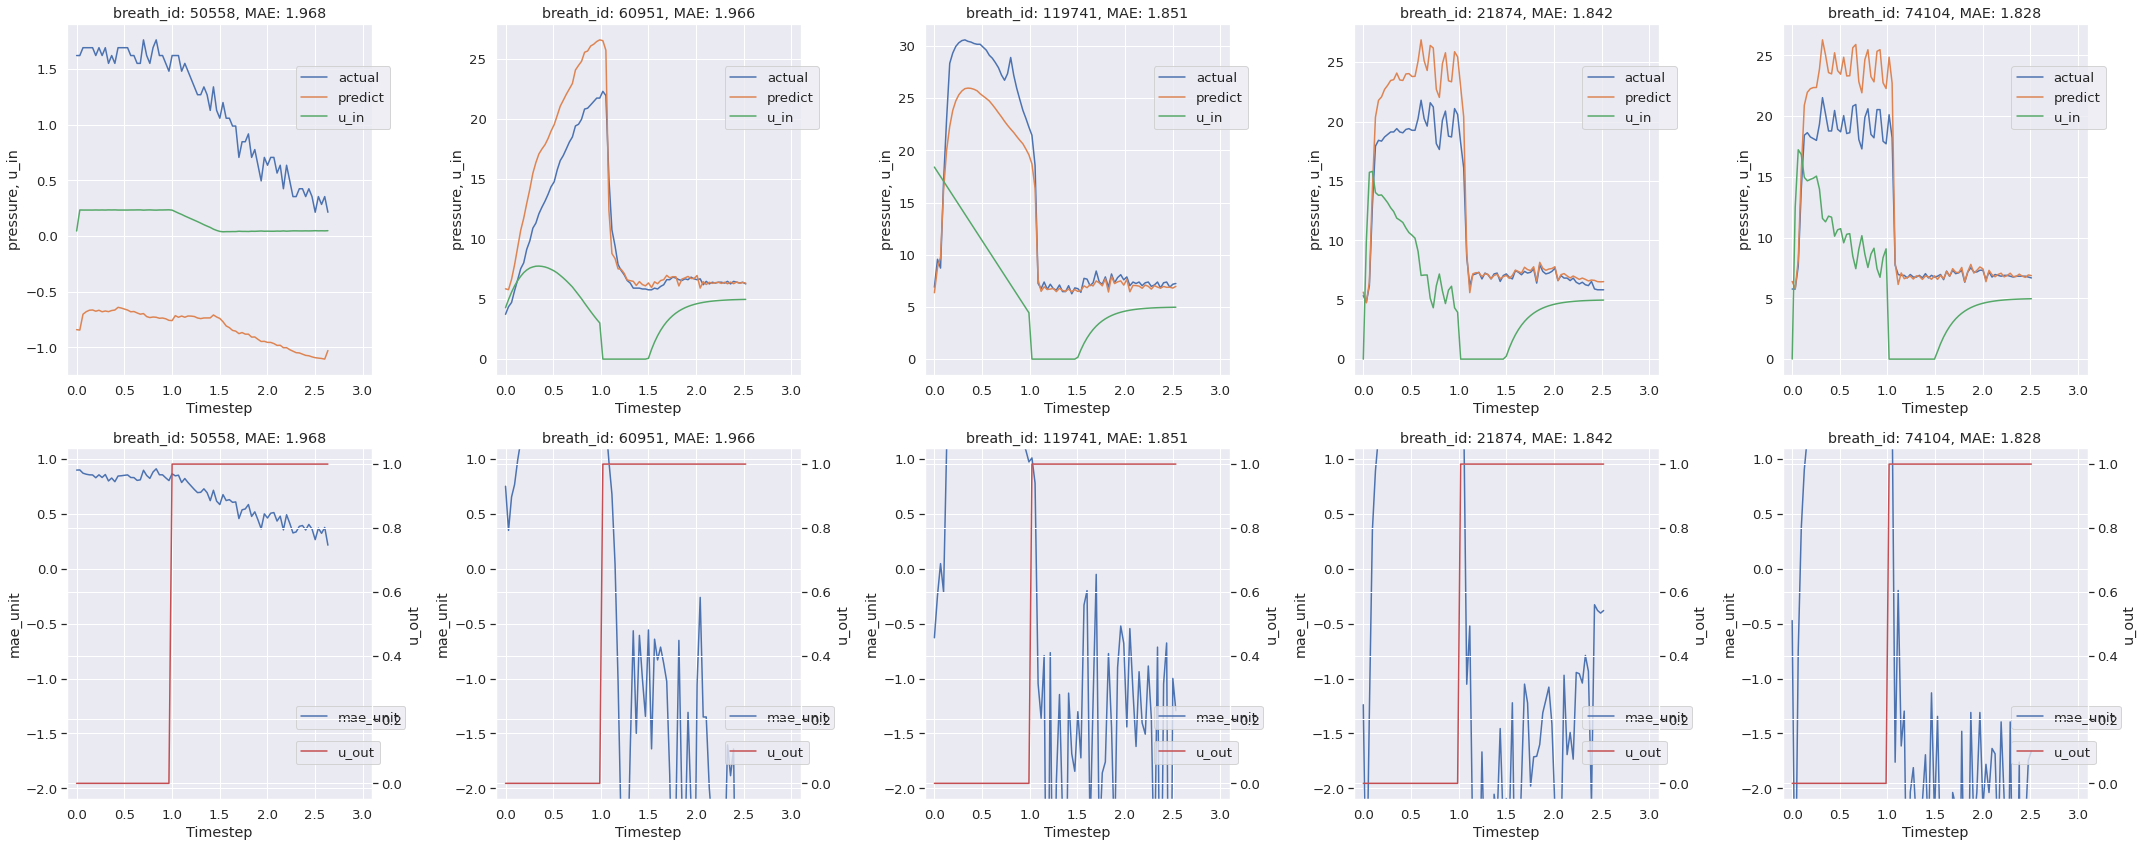

In [ ]:
# 予測値と実測値の波形図
shopw_length = 5
data = train_pred.sort_values("mae", ascending=False)[:80 * shopw_length]

lst_train_pred = data['breath_id'].unique()
print(lst_train_pred)

fig, ax = plt.subplots(2, shopw_length, figsize=(30, 12))
sns.set(font_scale=1.2)
for i, num in enumerate(lst_train_pred):
    df = data[data['breath_id']==num]

    sns.lineplot(data=df, x='time_step', y='pressure', label='actual', ax=ax[0, i])
    sns.lineplot(data=df, x='time_step', y='pred_pressure', label='predict', ax=ax[0, i])
    sns.lineplot(data=df, x='time_step', y='u_in', label='u_in', ax=ax[0, i])
    sns.lineplot(x=df['time_step'], y=np.log(df['mae_unit']), label='mae_unit', ax=ax[1, i])
    ax[0, i].set(xlabel='Timestep', ylabel='pressure, u_in', title=f'breath_id: {num}, MAE: {round(df["mae"].mean(), 3)}', xlim=(-0.1, 3.1))
    ax[0, i].legend(loc=(0.75, 0.7))
    ax[1, i].set(xlabel='Timestep', ylabel='mae_unit', title=f'breath_id: {num}, MAE: {round(df["mae"].mean(), 3)}', xlim=(-0.1, 3.1), ylim=(-2.1, 1.1))
    ax2 = ax[1, i].twinx()
    sns.lineplot(data=df, x='time_step', y='u_out', label='u_out', ax=ax2, color='r')
    ax[1, i].legend(loc=(0.75, 0.2))
    ax2.legend(loc=(0.75, 0.1))

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

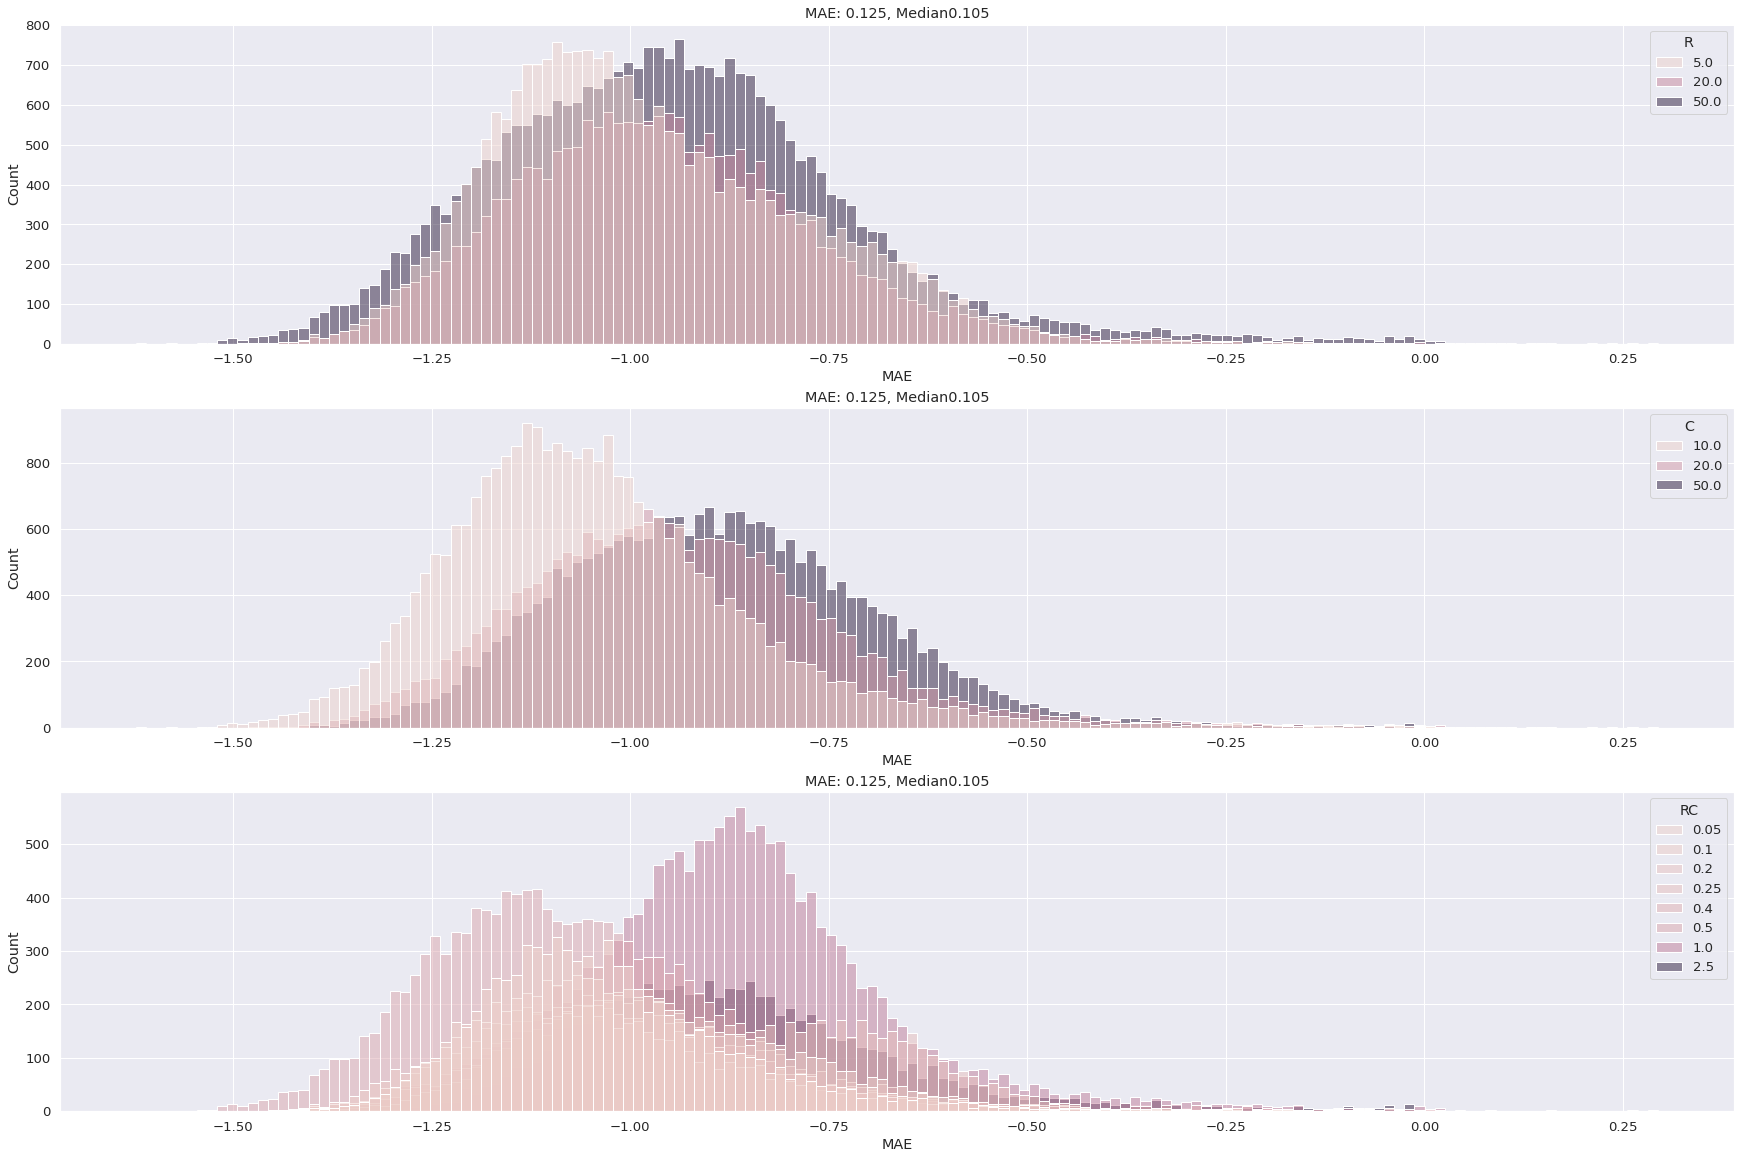

In [ ]:
# Histgram
hist_data = train_pred.groupby("breath_id")["mae", "R", "C", "RC"].mean()
fig, ax = plt.subplots(3, 1, figsize=(30, 20))
sns.set(font_scale=1.2)
for i, tag in tqdm(enumerate(["R", "C", "RC"])):
    sns.histplot(data=hist_data, x=np.log10(hist_data["mae"]), hue=tag, ax=ax[i])
    ax[i].set(xlabel='MAE', ylabel='Count', title=f'MAE: {round(hist_data["mae"].mean(), 3)}, Median{round(hist_data["mae"].median(), 3)}')
plt.show()

In [ ]:
# RC investigation
for rc in hist_data["RC"].unique():
    hist_tmp = hist_data[hist_data["RC"]==rc]
    print('RC: {0} score mean: {1:.4f}, std: {2:.4f}, Count: {3}'.format(rc, np.mean(hist_tmp["mae"]), np.std(hist_tmp["mae"]), len(hist_tmp["mae"])))

RC: 1.0 score mean: 0.1504, std: 0.0915, Count: 16380
RC: 0.4 score mean: 0.1143, std: 0.0605, Count: 6187
RC: 2.5 score mean: 0.1581, std: 0.1122, Count: 8161
RC: 0.25 score mean: 0.1404, std: 0.0691, Count: 8248
RC: 0.1 score mean: 0.1094, std: 0.0592, Count: 8254
RC: 0.5 score mean: 0.0997, std: 0.0853, Count: 13608
RC: 0.2 score mean: 0.1077, std: 0.0632, Count: 6041
RC: 0.05 score mean: 0.1047, std: 0.0661, Count: 8279


In [ ]:
# steady_state investigation
# for rc in hist_data["steady_state"].unique():
#     hist_tmp = hist_data[hist_data["steady_state"]==rc]
#     print('transient_f: {0} score mean: {1:.4f}, std: {2:.4f}, Count: {3}'.format(rc, np.mean(hist_tmp["mae"]), np.std(hist_tmp["mae"]), len(hist_tmp["mae"])))

In [ ]:
# # Histgram
# hist_data = train_pred.groupby("breath_id")["mae",　"transient_f"].mean()
# fig, ax = plt.subplots(4, 1, figsize=(30, 20))
# sns.set(font_scale=1.2)
# for i, tag in tqdm(enumerate(["transient_f"])):
#     sns.histplot(data=hist_data, x=np.log10(hist_data["mae"]), hue=tag, ax=ax[i])
#     ax[i].set(xlabel='MAE', ylabel='Count', title=f'MAE: {round(hist_data["mae"].mean(), 3)}, Median{round(hist_data["mae"].median(), 3)}')
# plt.show()

In [ ]:
# # transient_f investigation
# for rc in hist_data["steady_state"].unique():
#     hist_tmp = hist_data[hist_data["steady_state"]==rc]
#     print('transient_f: {0} score mean: {1:.4f}, std: {2:.4f}, Count: {3}'.format(rc, np.mean(hist_tmp["mae"]), np.std(hist_tmp["mae"]), len(hist_tmp["mae"])))